In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from urllib import request
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import speclite.filters as sp
from scipy.ndimage import sum_labels, mean


from astropy.io import fits
from astropy import units as u
from astropy import constants as c
from astropy.wcs import WCS

from ppxf.ppxf import ppxf, rebin
import ppxf.ppxf_util as util
from ppxf import sps_util as lib

import os
import sys
import glob

In [2]:
# Load spatial legacy map IC3392_individual.fits 
# --------- file location (edit if needed) ----------
legacy_path = Path("IC3392_legacy_voronoi_binned_extended.fits")
print("Loading:", legacy_path.resolve())
with fits.open(legacy_path) as hdul:
    # check data structure and header
    print(hdul.info())
    legacy_primary = hdul[0]
    legacy_BINID   = hdul[1].data
    legacy_FLUX    = hdul[2].data
    legacy_SNR     = hdul[3].data
    legacy_SNRBIN  = hdul[4].data
    legacy_XBIN    = hdul[5].data
    legacy_YBIN    = hdul[6].data
    legacy_FLUX_CALIBRATED = hdul[7].data
    legacy_ML      = hdul[8].data
    legacy_M       = hdul[9].data
    legacy_MAGNITUDE = hdul[10].data
    legacy_MAGNITUDE_UNCORRECTED = hdul[11].data
    legacy_hdr     = hdul[1].header
    hdul.close()

legacy_hdr


Loading: /Users/Igniz/Desktop/ICRAR/data/IC3392/IC3392_legacy_voronoi_binned_extended.fits
Filename: IC3392_legacy_voronoi_binned_extended.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  BINID         1 PrimaryHDU      23   ()      
  1  BINID         1 ImageHDU        26   (437, 438)   float64   
  2  FLUX          1 ImageHDU        27   (437, 438, 4)   float32   
  3  SNR           1 ImageHDU        27   (437, 438, 4)   float32   
  4  SNRBIN        1 ImageHDU        27   (437, 438, 4)   float32   
  5  XBIN          1 ImageHDU        26   (437, 438)   float32   
  6  YBIN          1 ImageHDU        26   (437, 438)   float32   
  7  FLUX_CALIBRATED    1 ImageHDU        28   (437, 438, 4)   float32   
  8  ML            1 ImageHDU        28   (437, 438, 4)   float32   
  9  M             1 ImageHDU        27   (437, 438)   float64   
 10  MAGNITUDE     1 ImageHDU        29   (437, 438, 4)   float32   
 11  MAGNITUDE_UNCORRECTED    1 ImageHDU        29   (437, 4

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  437                                                  
NAXIS2  =                  438                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =      216.43244136583 / Pixel coordinate of reference point            
CRPIX2  =      219.93673592818 / Pixel coordinate of reference point            
CDELT1  = -5.5555555555556E-05 / [deg] Coordinate increment at reference point  
CDELT2  =  5.5555555555556E-05 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'             

In [3]:
# r-band map
legacy_ML_r = legacy_ML[1]
legacy_MAGNITUDE_r = legacy_MAGNITUDE[1]
legacy_MAGNITUDE_UNCORRECTED_r = legacy_MAGNITUDE_UNCORRECTED[1]

In [4]:
# find bounding box of finite Spaxels
nonnan = ~np.isnan(legacy_MAGNITUDE_r)
ys, xs = np.where(nonnan)
ymin, ymax = ys.min(), ys.max()
xmin, xmax = xs.min(), xs.max()

# compute half-widths of that box
half_w = (xmax - xmin) // 2
half_h = (ymax - ymin) // 2

# integer center from previous fit
cx_i, cy_i = legacy_MAGNITUDE_r.shape
cx_i = cx_i // 2
cy_i = cy_i // 2

# build zoom window centered on (cx, cy)
xmin_zoom = max(cx_i - half_w, 0)
xmax_zoom = min(cx_i + half_w, legacy_MAGNITUDE_r.shape[1] - 1)
ymin_zoom = max(cy_i - half_h, 0)
ymax_zoom = min(cy_i + half_h, legacy_MAGNITUDE_r.shape[0] - 1)

half_zoom = np.max(np.array([xmax_zoom-xmin_zoom, ymax_zoom-ymin_zoom])) // 2

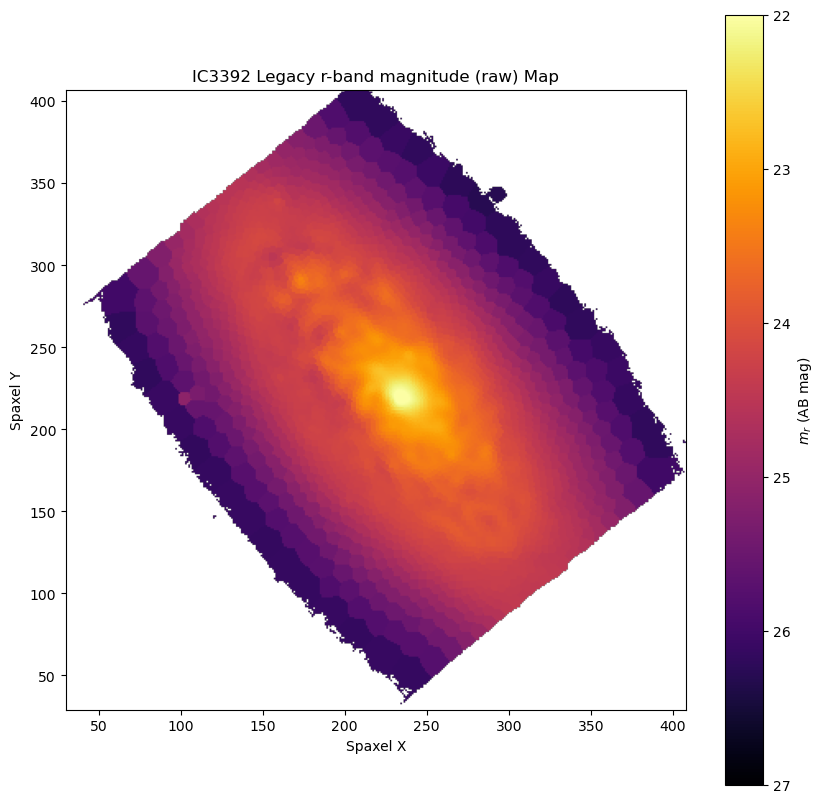

In [5]:
plt.figure(figsize=(10, 10))
im = plt.imshow(legacy_MAGNITUDE_UNCORRECTED_r, origin='lower', cmap='inferno_r', vmin=22, vmax=27)
plt.colorbar(im, label=r'$m_r$ (AB mag)').ax.invert_yaxis()
plt.xlim(cx_i-half_zoom, cx_i+half_zoom)
plt.ylim(cy_i-half_zoom, cy_i+half_zoom)
# plt.axis('equal')               # force equal scaling on x and y

plt.title(f"IC3392 Legacy r-band magnitude (raw) Map")
plt.xlabel("Spaxel X")
plt.ylabel("Spaxel Y")
plt.show()

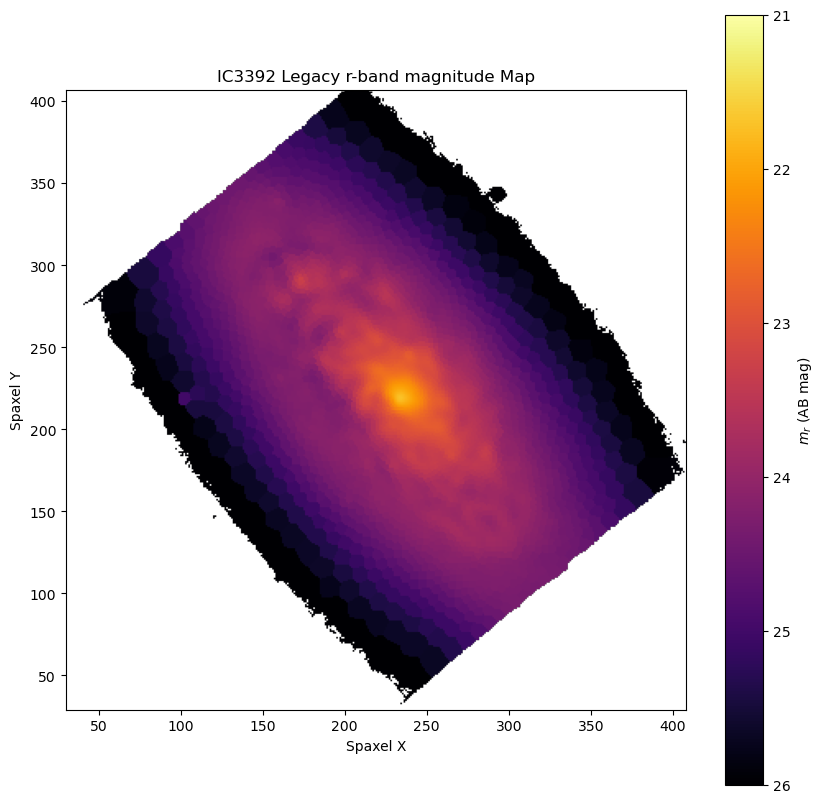

In [6]:
plt.figure(figsize=(10, 10))
im = plt.imshow(legacy_MAGNITUDE_r, origin='lower', cmap='inferno_r', vmin=21, vmax=26)
plt.colorbar(im, label=r'$m_r$ (AB mag)').ax.invert_yaxis()
plt.xlim(cx_i-half_zoom, cx_i+half_zoom)
plt.ylim(cy_i-half_zoom, cy_i+half_zoom)
# plt.axis('equal')               # force equal scaling on x and y

plt.title(f"IC3392 Legacy r-band magnitude Map")
plt.xlabel("Spaxel X")
plt.ylabel("Spaxel Y")
plt.show()

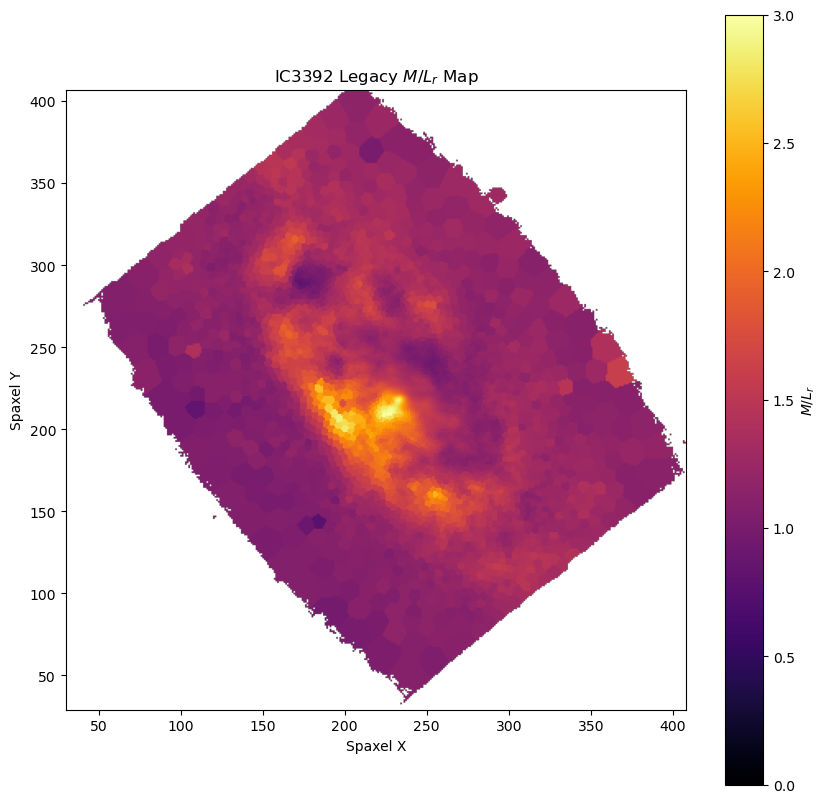

In [7]:
plt.figure(figsize=(10, 10))
im = plt.imshow(legacy_ML_r, origin='lower', cmap='inferno', vmin=0, vmax=3)
plt.colorbar(im, label=r'$M/L_r$')
plt.xlim(cx_i-half_zoom, cx_i+half_zoom)
plt.ylim(cy_i-half_zoom, cy_i+half_zoom)
# plt.axis('equal')               # force equal scaling on x and y

plt.title(f"IC3392 Legacy $M/L_r$ Map")
plt.xlabel("Spaxel X")
plt.ylabel("Spaxel Y")
plt.show()

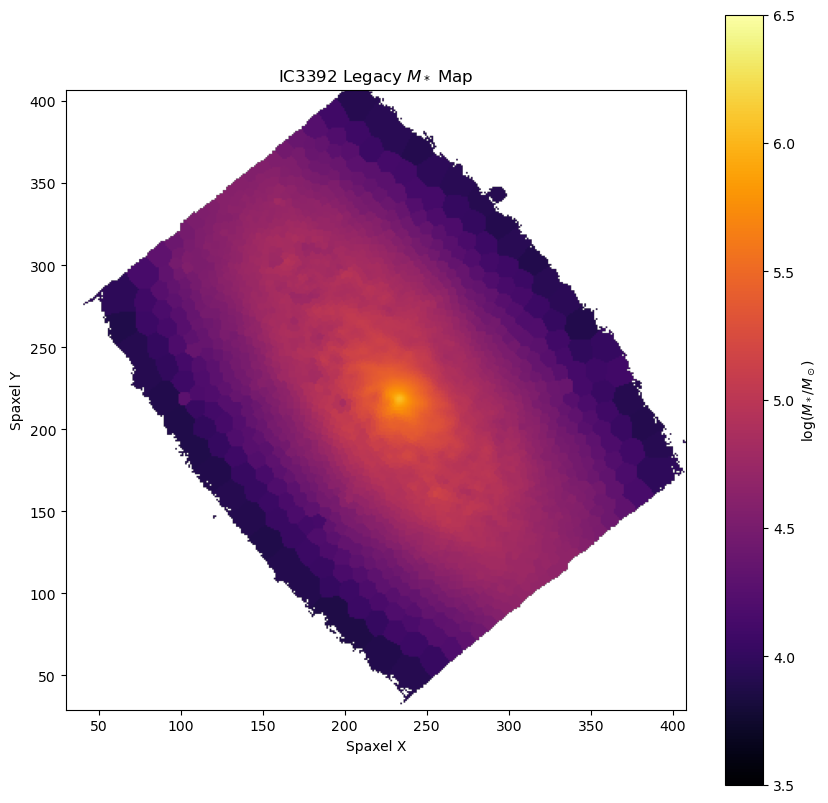

In [8]:
plt.figure(figsize=(10, 10))
im = plt.imshow(legacy_M, origin='lower', cmap='inferno', vmin=3.5, vmax=6.5)
plt.colorbar(im, label=r'$\log(M_*/M_\odot)$')
plt.xlim(cx_i-half_zoom, cx_i+half_zoom)
plt.ylim(cy_i-half_zoom, cy_i+half_zoom)
# plt.axis('equal')               # force equal scaling on x and y

plt.title(f"IC3392 Legacy $M_*$ Map")
plt.xlabel("Spaxel X")
plt.ylabel("Spaxel Y")
plt.show()

In [9]:
# Load spatial MAUVE map IC3392_individual.fits 
# --------- file location (edit if needed) ----------
MAUVE_path = Path("IC3392_SPATIAL_BINNING_maps_extended.fits")
print("Loading:", MAUVE_path.resolve())
with fits.open(MAUVE_path) as hdul:
    # check data structure and header
    print(hdul.info())
    MAUVE_primary = hdul[0]
    MAUVE_BINID   = hdul[1].data
    MAUVE_FLUX    = hdul[2].data
    MAUVE_SNR     = hdul[3].data
    MAUVE_SNRBIN  = hdul[4].data
    MAUVE_XBIN    = hdul[5].data
    MAUVE_YBIN    = hdul[6].data
    MAUVE_FLUX_R_corr = hdul[7].data
    MAUVE_ML_R    = hdul[8].data
    MAUVE_LOGMSTAR= hdul[9].data
    MAUVE_MAGNITUDE_R = hdul[10].data
    MAUVE_MAGNITUDE_R_UNCORRECTED = hdul[11].data
    MAUVE_hdr     = hdul[1].header
    hdul.close()

MAUVE_hdr

Loading: /Users/Igniz/Desktop/ICRAR/data/IC3392/IC3392_SPATIAL_BINNING_maps_extended.fits
Filename: IC3392_SPATIAL_BINNING_maps_extended.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  BINID         1 ImageHDU        26   (437, 438)   float64   
  2  FLUX          1 ImageHDU        26   (437, 438)   float64   
  3  SNR           1 ImageHDU        26   (437, 438)   float64   
  4  SNRBIN        1 ImageHDU        26   (437, 438)   float64   
  5  XBIN          1 ImageHDU        26   (437, 438)   float64   
  6  YBIN          1 ImageHDU        26   (437, 438)   float64   
  7  FLUX_R_corr    1 ImageHDU        27   (437, 438)   float64   
  8  ML_R          1 ImageHDU        27   (437, 438)   float64   
  9  LOGMSTAR      1 ImageHDU        27   (437, 438)   float64   
 10  MAGNITUDE_R    1 ImageHDU        27   (437, 438)   float64   
 11  MAGNITUDE_R_UNCORRECTED    1 ImageHDU        27   (437, 438)   float64   
None

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  437                                                  
NAXIS2  =                  438                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =      216.43244136583 / Pixel coordinate of reference point            
CRPIX2  =      219.93673592818 / Pixel coordinate of reference point            
CDELT1  = -5.5555555555556E-05 / [deg] Coordinate increment at reference point  
CDELT2  =  5.5555555555556E-05 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'             

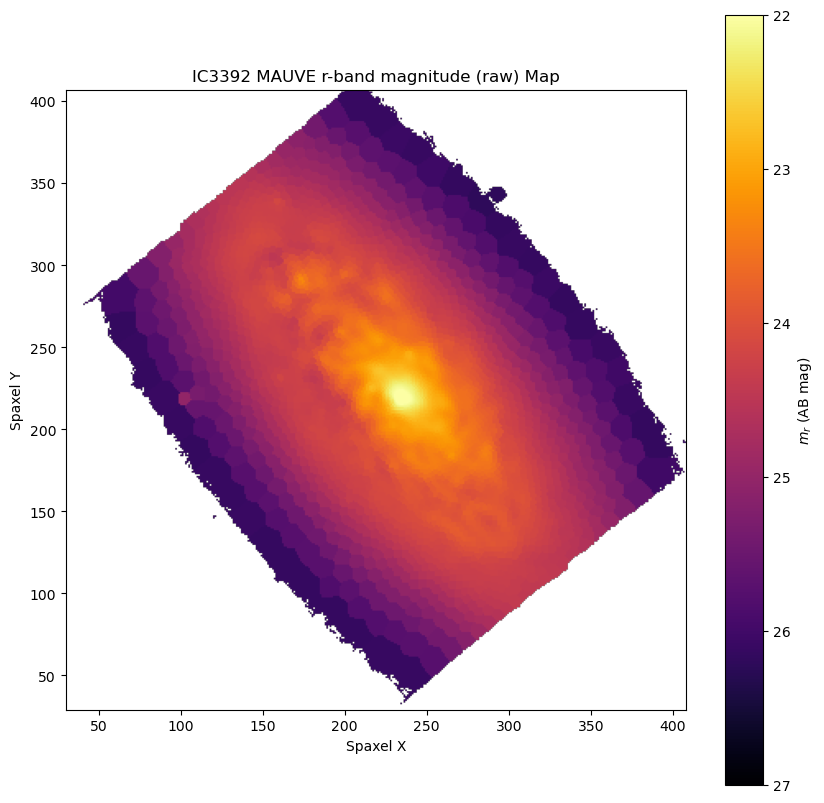

In [10]:
plt.figure(figsize=(10, 10))
im = plt.imshow(MAUVE_MAGNITUDE_R_UNCORRECTED, origin='lower', cmap='inferno_r', vmin=22, vmax=27)
plt.colorbar(im, label=r'$m_r$ (AB mag)').ax.invert_yaxis()
plt.xlim(cx_i-half_zoom, cx_i+half_zoom)
plt.ylim(cy_i-half_zoom, cy_i+half_zoom)
# plt.axis('equal')               # force equal scaling on x and y

plt.title(f"IC3392 MAUVE r-band magnitude (raw) Map")
plt.xlabel("Spaxel X")
plt.ylabel("Spaxel Y")
plt.show()

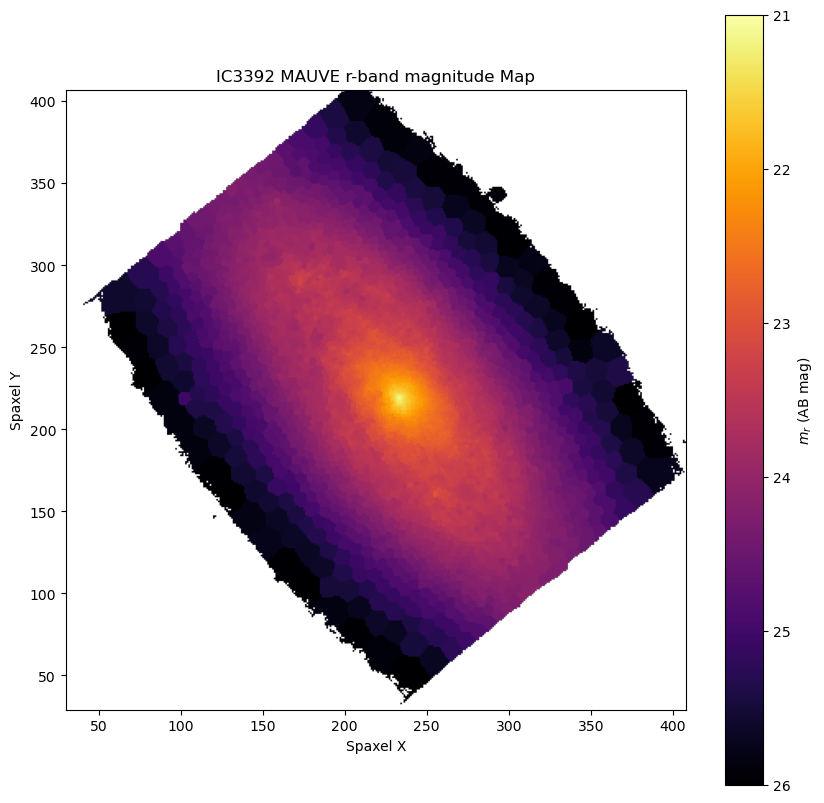

In [11]:
plt.figure(figsize=(10, 10))
im = plt.imshow(MAUVE_MAGNITUDE_R, origin='lower', cmap='inferno_r', vmin=21, vmax=26)
plt.colorbar(im, label=r'$m_r$ (AB mag)').ax.invert_yaxis()
plt.xlim(cx_i-half_zoom, cx_i+half_zoom)
plt.ylim(cy_i-half_zoom, cy_i+half_zoom)
# plt.axis('equal')               # force equal scaling on x and y

plt.title(f"IC3392 MAUVE r-band magnitude Map")
plt.xlabel("Spaxel X")
plt.ylabel("Spaxel Y")
plt.show()

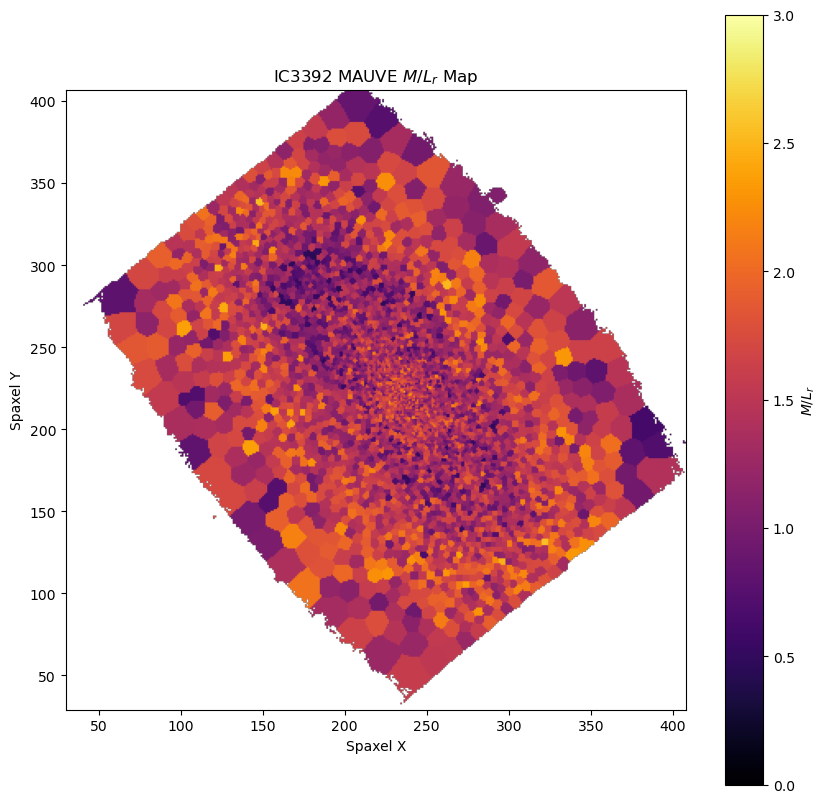

In [12]:
plt.figure(figsize=(10, 10))
im = plt.imshow(MAUVE_ML_R, origin='lower', cmap='inferno', vmin=0, vmax=3)
plt.colorbar(im, label=r'$M/L_r$')
plt.xlim(cx_i-half_zoom, cx_i+half_zoom)
plt.ylim(cy_i-half_zoom, cy_i+half_zoom)
# plt.axis('equal')               # force equal scaling on x and y

plt.title(f"IC3392 MAUVE $M/L_r$ Map")
plt.xlabel("Spaxel X")
plt.ylabel("Spaxel Y")
plt.show()

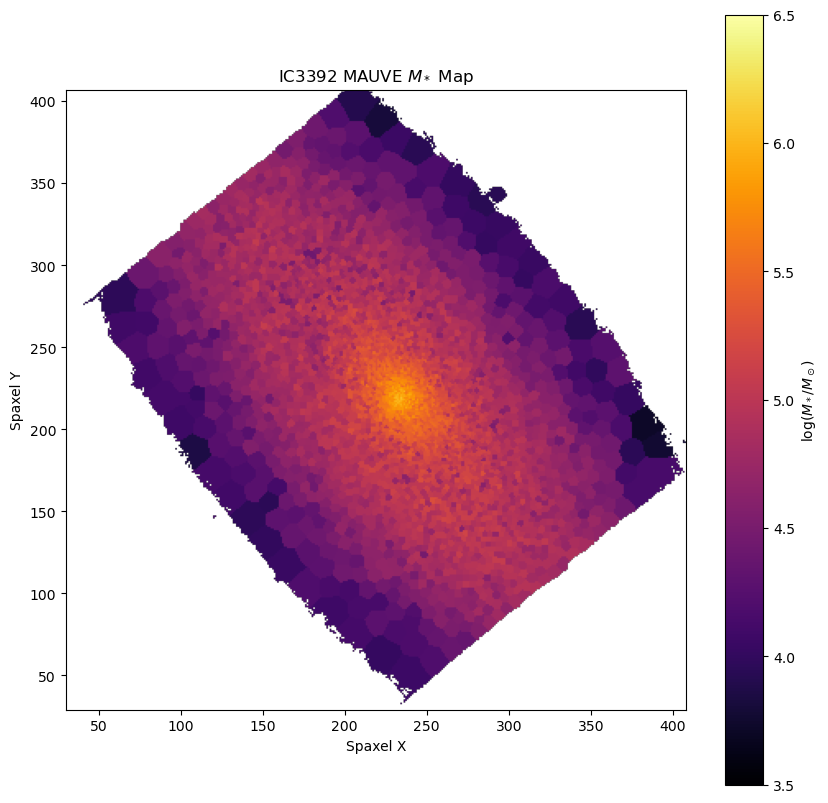

In [13]:
plt.figure(figsize=(10, 10))
im = plt.imshow(MAUVE_LOGMSTAR, origin='lower', cmap='inferno', vmin=3.5, vmax=6.5)
plt.colorbar(im, label=r'$\log(M_*/M_\odot)$')
plt.xlim(cx_i-half_zoom, cx_i+half_zoom)
plt.ylim(cy_i-half_zoom, cy_i+half_zoom)
# plt.axis('equal')               # force equal scaling on x and y

plt.title(f"IC3392 MAUVE $M_*$ Map")
plt.xlabel("Spaxel X")
plt.ylabel("Spaxel Y")
plt.show()

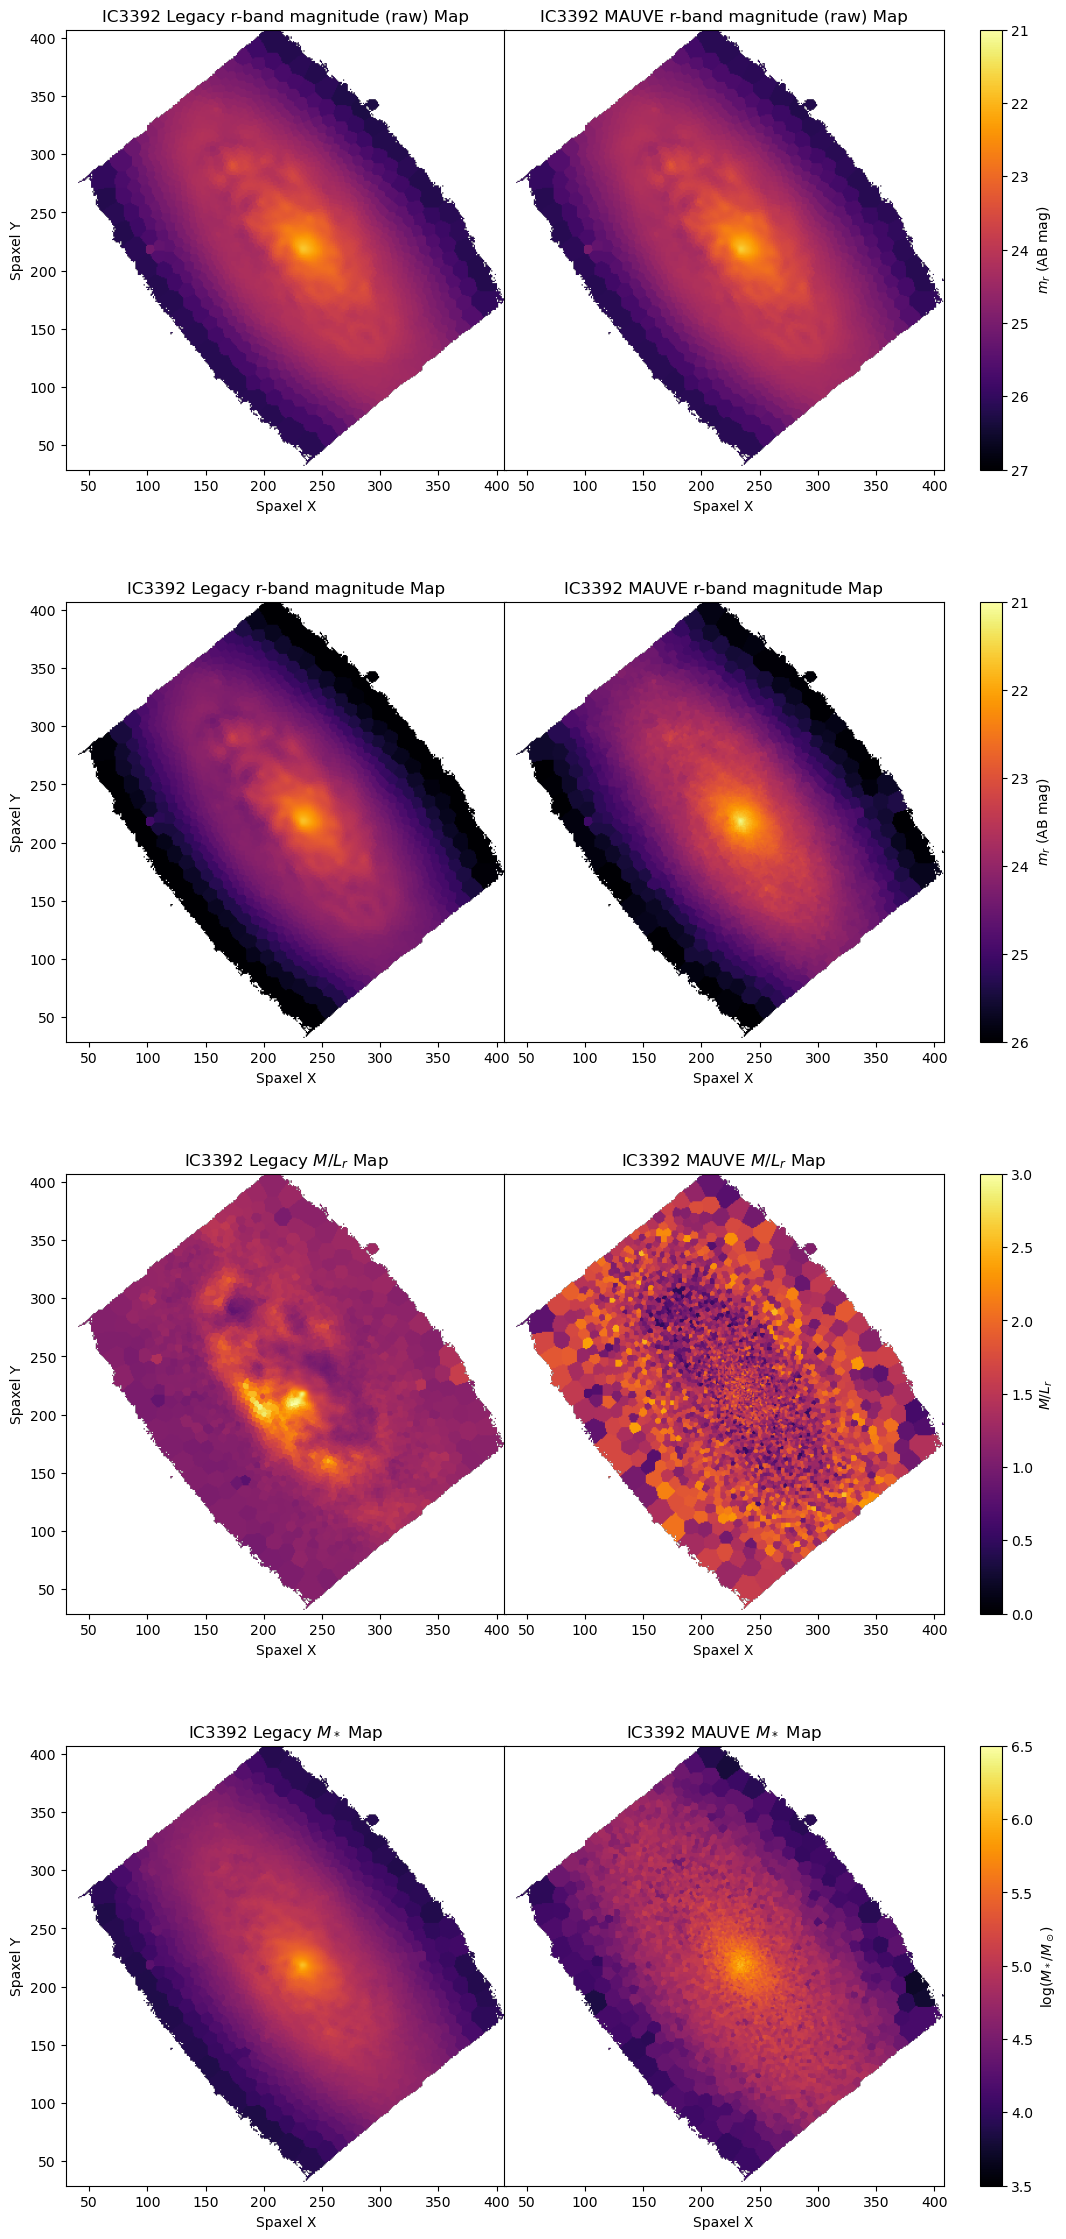

In [14]:
fig, axes = plt.subplots(4, 2, figsize=(15, 28))

# Remove spacing between subplots
plt.subplots_adjust(wspace=-0.388, hspace=0.3)

# First row: Uncorrected magnitude maps
# Legacy uncorrected magnitude (left)
im0 = axes[0,0].imshow(legacy_MAGNITUDE_UNCORRECTED_r, origin='lower', cmap='inferno_r', 
                       vmin=21, vmax=27
                       )
axes[0,0].set_xlim(cx_i-half_zoom, cx_i+half_zoom)
axes[0,0].set_ylim(cy_i-half_zoom, cy_i+half_zoom)
axes[0,0].set_title("IC3392 Legacy r-band magnitude (raw) Map")
axes[0,0].set_xlabel("Spaxel X")
axes[0,0].set_ylabel("Spaxel Y")

# MAUVE uncorrected magnitude (right)
im0_r = axes[0,1].imshow(MAUVE_MAGNITUDE_R_UNCORRECTED, origin='lower', cmap='inferno_r', 
                       vmin=21, vmax=27
                       )
cbar0 = plt.colorbar(im0_r, ax=axes[0,1], label=r'$m_r$ (AB mag)')
cbar0.ax.invert_yaxis()
axes[0,1].set_xlim(cx_i-half_zoom, cx_i+half_zoom)
axes[0,1].set_ylim(cy_i-half_zoom, cy_i+half_zoom)
axes[0,1].set_title("IC3392 MAUVE r-band magnitude (raw) Map")
axes[0,1].set_xlabel("Spaxel X")
axes[0,1].tick_params(left=False, labelleft=False)

# Second row: Corrected magnitude maps
# Legacy magnitude (left)
im1 = axes[1,0].imshow(legacy_MAGNITUDE_r, origin='lower', cmap='inferno_r', 
                       vmin=21, vmax=26)
axes[1,0].set_xlim(cx_i-half_zoom, cx_i+half_zoom)
axes[1,0].set_ylim(cy_i-half_zoom, cy_i+half_zoom)
axes[1,0].set_title("IC3392 Legacy r-band magnitude Map")
axes[1,0].set_xlabel("Spaxel X")
axes[1,0].set_ylabel("Spaxel Y")

# MAUVE magnitude (right)
im2 = axes[1,1].imshow(MAUVE_MAGNITUDE_R, origin='lower', cmap='inferno_r', 
                       vmin=21, vmax=26)
cbar2 = plt.colorbar(im2, ax=axes[1,1], label=r'$m_r$ (AB mag)')
cbar2.ax.invert_yaxis()
axes[1,1].set_xlim(cx_i-half_zoom, cx_i+half_zoom)
axes[1,1].set_ylim(cy_i-half_zoom, cy_i+half_zoom)
axes[1,1].set_title("IC3392 MAUVE r-band magnitude Map")
axes[1,1].set_xlabel("Spaxel X")
axes[1,1].tick_params(left=False, labelleft=False)

# Third row: M/L maps
# Legacy M/L (left)
im3 = axes[2,0].imshow(legacy_ML_r, origin='lower', cmap='inferno', vmin=0, vmax=3)
axes[2,0].set_xlim(cx_i-half_zoom, cx_i+half_zoom)
axes[2,0].set_ylim(cy_i-half_zoom, cy_i+half_zoom)
axes[2,0].set_title("IC3392 Legacy $M/L_r$ Map")
axes[2,0].set_xlabel("Spaxel X")
axes[2,0].set_ylabel("Spaxel Y")

# MAUVE M/L (right)
im4 = axes[2,1].imshow(MAUVE_ML_R, origin='lower', cmap='inferno', vmin=0, vmax=3)
plt.colorbar(im4, ax=axes[2,1], label=r'$M/L_r$')
axes[2,1].set_xlim(cx_i-half_zoom, cx_i+half_zoom)
axes[2,1].set_ylim(cy_i-half_zoom, cy_i+half_zoom)
axes[2,1].set_title("IC3392 MAUVE $M/L_r$ Map")
axes[2,1].set_xlabel("Spaxel X")
axes[2,1].tick_params(left=False, labelleft=False)

# Fourth row: Stellar mass maps
# Legacy stellar mass (left)
im5 = axes[3,0].imshow(legacy_M, origin='lower', cmap='inferno', vmin=3.5, vmax=6.5)
axes[3,0].set_xlim(cx_i-half_zoom, cx_i+half_zoom)
axes[3,0].set_ylim(cy_i-half_zoom, cy_i+half_zoom)
axes[3,0].set_title("IC3392 Legacy $M_*$ Map")
axes[3,0].set_xlabel("Spaxel X")
axes[3,0].set_ylabel("Spaxel Y")

# MAUVE stellar mass (right)
im6 = axes[3,1].imshow(MAUVE_LOGMSTAR, origin='lower', cmap='inferno', vmin=3.5, vmax=6.5)
plt.colorbar(im6, ax=axes[3,1], label=r'$\log(M_*/M_\odot)$')
axes[3,1].set_xlim(cx_i-half_zoom, cx_i+half_zoom)
axes[3,1].set_ylim(cy_i-half_zoom, cy_i+half_zoom)
axes[3,1].set_title("IC3392 MAUVE $M_*$ Map")
axes[3,1].set_xlabel("Spaxel X")
axes[3,1].tick_params(left=False, labelleft=False)

plt.show()


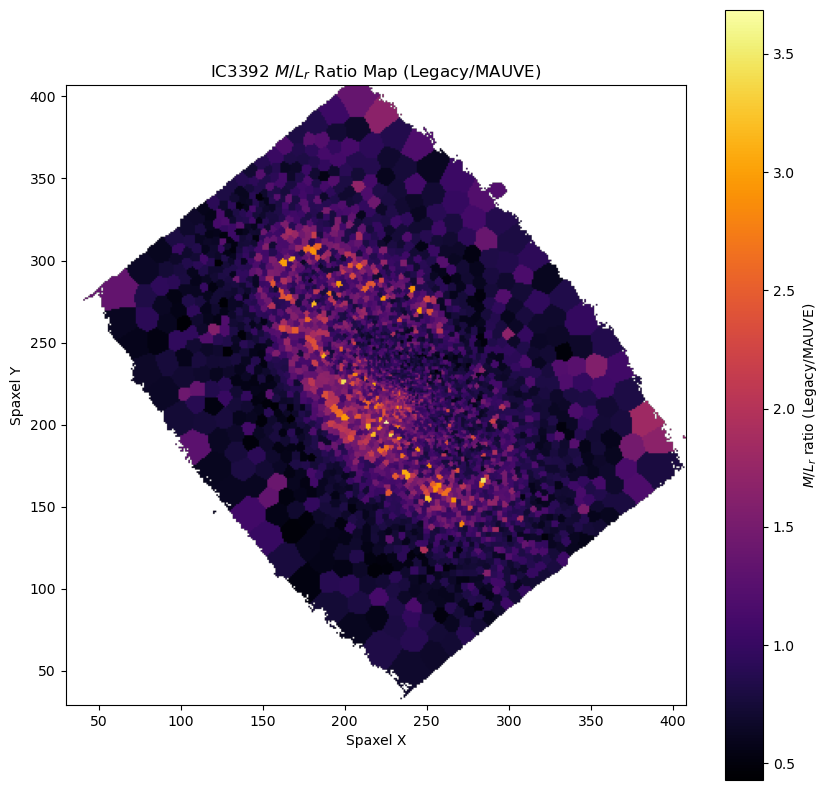

In [15]:
# Plot M/L_r ratio (legacy/MAUVE)
M_L_ratio = legacy_ML_r / MAUVE_ML_R
plt.figure(figsize=(10, 10))
im = plt.imshow(M_L_ratio, origin='lower', cmap='inferno')
plt.colorbar(im, label=r'$M/L_r$ ratio (Legacy/MAUVE)')
plt.xlim(cx_i-half_zoom, cx_i+half_zoom)
plt.ylim(cy_i-half_zoom, cy_i+half_zoom)
plt.title(f"IC3392 $M/L_r$ Ratio Map (Legacy/MAUVE)")
plt.xlabel("Spaxel X")
plt.ylabel("Spaxel Y")
plt.show()

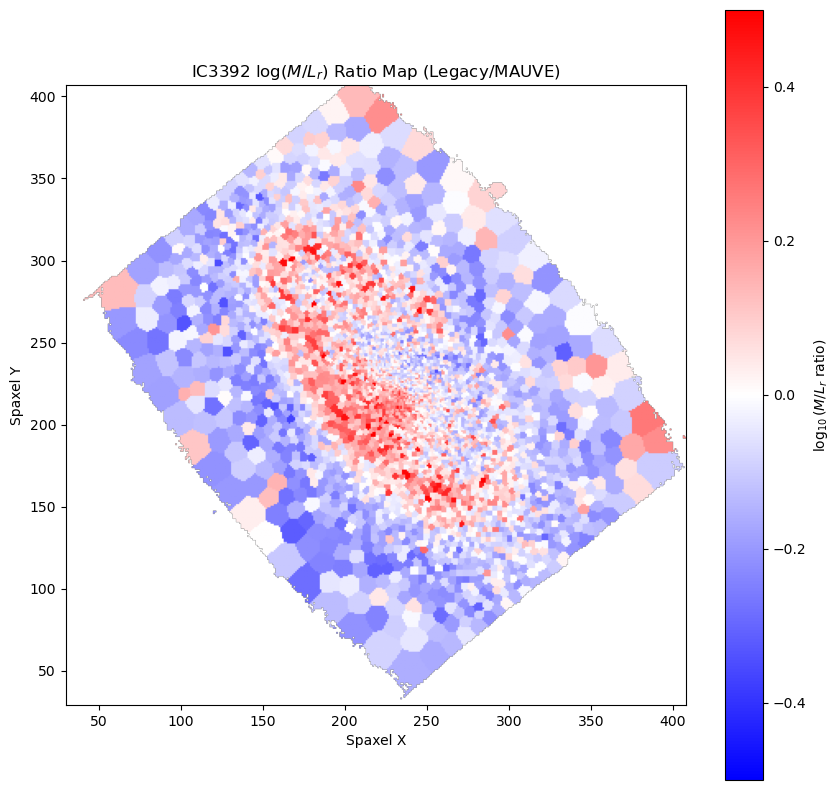

In [16]:
# Plot log10 of the M/Lₙ ratio (legacy/MAUVE)
M_L_ratio_log = np.log10(legacy_ML_r / MAUVE_ML_R)
plt.figure(figsize=(10, 10))
im = plt.imshow(M_L_ratio_log, origin='lower', cmap='bwr', vmin=-0.5, vmax=0.5)
plt.colorbar(im, label=r'$\log_{10}(M/L_r\ \mathrm{ratio})$')
plt.xlim(cx_i-half_zoom, cx_i+half_zoom)
plt.ylim(cy_i-half_zoom, cy_i+half_zoom)
plt.title(r"IC3392 $\log(M/L_r)$ Ratio Map (Legacy/MAUVE)")
plt.xlabel("Spaxel X")
plt.ylabel("Spaxel Y")
plt.show()

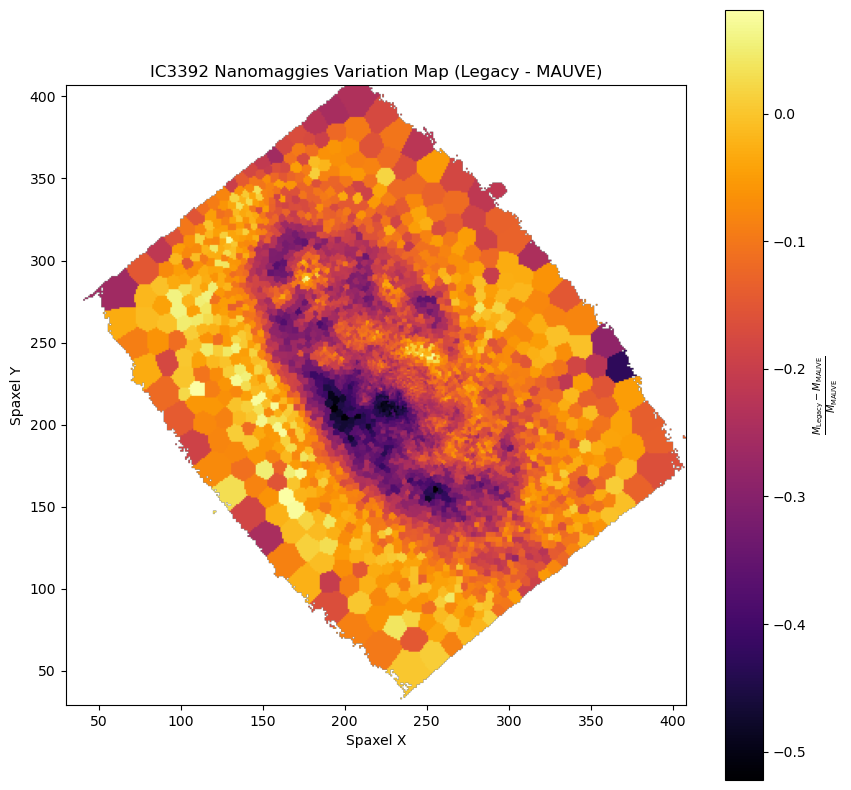

In [20]:
def magnitude_to_nanomaggies(magnitude):
    return 10**((22.5 - magnitude) / 2.5)
# Convert Legacy and MAUVE magnitudes to nanomaggies
legacy_nanomaggies = magnitude_to_nanomaggies(legacy_MAGNITUDE_r)
mauve_nanomaggies = magnitude_to_nanomaggies(MAUVE_MAGNITUDE_R)
# Plot the variation of the nanomaggies ratio
nanomaggies_variation = (legacy_nanomaggies - mauve_nanomaggies)/mauve_nanomaggies
plt.figure(figsize=(10, 10))
im = plt.imshow(nanomaggies_variation, origin='lower', cmap='inferno', 
                # vmin=-0.1, vmax=0.1
                )
plt.colorbar(im, label=r'$\frac{M_\mathrm{Legacy} - M_\mathrm{MAUVE}}{M_\mathrm{MAUVE}}$')
plt.xlim(cx_i-half_zoom, cx_i+half_zoom)
plt.ylim(cy_i-half_zoom, cy_i+half_zoom)
plt.title("IC3392 Nanomaggies Variation Map (Legacy - MAUVE)")
plt.xlabel("Spaxel X")
plt.ylabel("Spaxel Y")
plt.show()

In [21]:
np.nansum(legacy_nanomaggies), np.nansum(mauve_nanomaggies)

(np.float32(12773.863), np.float64(15623.583098781308))